https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_kernel_approximation.html#sphx-glr-auto-examples-miscellaneous-plot-kernel-approximation-py

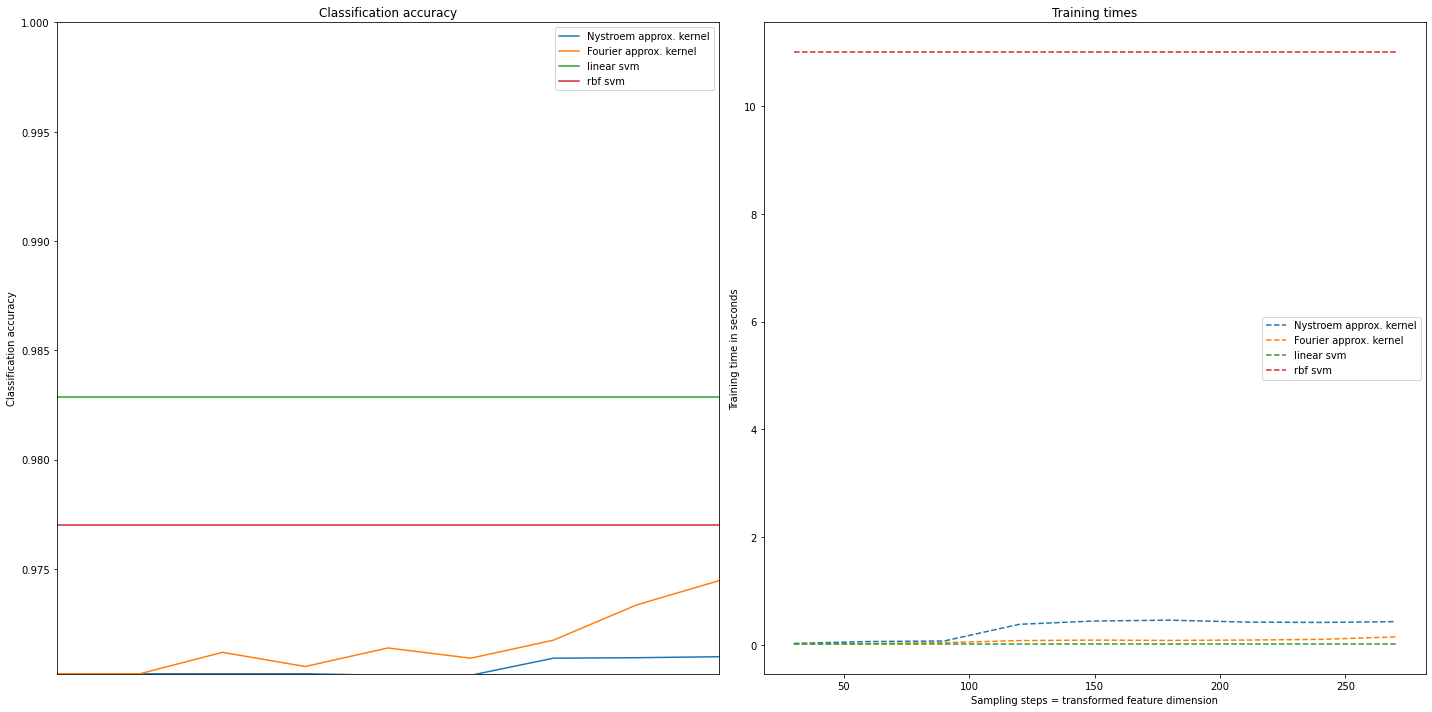

In [3]:
# Author: Gael Varoquaux <gael dot varoquaux at normalesup dot org>
#         Andreas Mueller <amueller@ais.uni-bonn.de>
# License: BSD 3 clause

# Standard scientific Python imports
from time import time

import matplotlib.pyplot as plt
import numpy as np

# Import datasets, classifiers and performance metrics
from sklearn import datasets, pipeline, svm
from sklearn.kernel_approximation import Nystroem, RBFSampler
from get_data import get_data


database = 'w3a'
# data_test = scaler.transform(data_test)
# 'kernel_svm__C': 0.01, 'kernel_svm__gamma': 3.25e-06
data_train, targets_train, data_test, targets_test = get_data(database)
n_samples, n_features = data_train.shape

dual_state = False
gamma =  3.25e-06 #0.1
c = 1
# Create a classifier: a support vector classifier
kernel_svm = svm.SVC(gamma=gamma, C = c)
linear_svm = svm.LinearSVC(dual=dual_state, random_state=42, C=c)

# create pipeline from kernel approximation
# and linear svm
feature_map_fourier = RBFSampler(gamma=gamma, random_state=1)
feature_map_nystroem = Nystroem(gamma=gamma, random_state=1)
fourier_approx_svm = pipeline.Pipeline(
    [
        ("feature_map", feature_map_fourier),
        ("svm", svm.LinearSVC(dual=dual_state, random_state=42)),
    ]
)

nystroem_approx_svm = pipeline.Pipeline(
    [
        ("feature_map", feature_map_nystroem),
        ("svm", svm.LinearSVC(dual=dual_state, random_state=42)),
    ]
)

# fit and predict using linear and kernel svm:

kernel_svm_time = time()
kernel_svm.fit(data_train, targets_train)
kernel_svm_score = kernel_svm.score(data_test, targets_test)
kernel_svm_time = time() - kernel_svm_time

linear_svm_time = time()
linear_svm.fit(data_train, targets_train)
linear_svm_score = linear_svm.score(data_test, targets_test)
linear_svm_time = time() - linear_svm_time

sample_sizes = 30 * np.arange(1, 10)
fourier_scores = []
nystroem_scores = []
fourier_times = []
nystroem_times = []

for D in sample_sizes:
    fourier_approx_svm.set_params(feature_map__n_components=D)
    nystroem_approx_svm.set_params(feature_map__n_components=D)
    start = time()
    nystroem_approx_svm.fit(data_train, targets_train)
    nystroem_times.append(time() - start)

    start = time()
    fourier_approx_svm.fit(data_train, targets_train)
    fourier_times.append(time() - start)

    fourier_score = fourier_approx_svm.score(data_test, targets_test)
    nystroem_score = nystroem_approx_svm.score(data_test, targets_test)
    nystroem_scores.append(nystroem_score)
    fourier_scores.append(fourier_score)

# plot the results:
plt.figure(figsize=(20, 10))
accuracy = plt.subplot(121)
# second y axis for timings
timescale = plt.subplot(122)

accuracy.plot(sample_sizes, nystroem_scores, label="Nystroem approx. kernel")
timescale.plot(sample_sizes, nystroem_times, "--", label="Nystroem approx. kernel")

accuracy.plot(sample_sizes, fourier_scores, label="Fourier approx. kernel")
timescale.plot(sample_sizes, fourier_times, "--", label="Fourier approx. kernel")

# horizontal lines for exact rbf and linear kernels:
accuracy.plot(
    [sample_sizes[0], sample_sizes[-1]],
    [linear_svm_score, linear_svm_score],
    label="linear svm",
)
timescale.plot(
    [sample_sizes[0], sample_sizes[-1]],
    [linear_svm_time, linear_svm_time],
    "--",
    label="linear svm",
)

accuracy.plot(
    [sample_sizes[0], sample_sizes[-1]],
    [kernel_svm_score, kernel_svm_score],
    label="rbf svm",
)
timescale.plot(
    [sample_sizes[0], sample_sizes[-1]],
    [kernel_svm_time, kernel_svm_time],
    "--",
    label="rbf svm",
)


# legends and labels
accuracy.set_title("Classification accuracy")
timescale.set_title("Training times")
accuracy.set_xlim(sample_sizes[0], sample_sizes[-1])
accuracy.set_xticks(())
accuracy.set_ylim(np.min(fourier_scores), 1)
timescale.set_xlabel("Sampling steps = transformed feature dimension")
accuracy.set_ylabel("Classification accuracy")
timescale.set_ylabel("Training time in seconds")
accuracy.legend(loc="best")
timescale.legend(loc="best")
plt.tight_layout()
plt.show()


